In [1]:
import os
import math
import time
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, Module
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics import AUROC, Accuracy, MeanSquaredError
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from torch_frame import stype
from torch_frame.data import Dataset, DataLoader
from torch_frame.datasets import (
    ForestCoverType, KDDCensusIncome, DataFrameBenchmark,
    AdultCensusIncome, BankMarketing, Dota2
)
from torch_frame.gbdt import CatBoost, LightGBM, XGBoost
from torch_frame.nn import (
    EmbeddingEncoder, FTTransformer, LinearBucketEncoder,
    LinearEncoder, LinearPeriodicEncoder, ResNet, TabNet, TabTransformer
)
from torch_frame.nn.models import (
    MLP, ExcelFormer, Trompt
)
from torch_frame.typing import TaskType



# Use GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv("Breast_Cancer.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Status'] = le.fit_transform(df['Status'])
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,0
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,0
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,0
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,0
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,0


# AutoEncoder

In [5]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded  # Bottleneck layer 값 반환

In [6]:
# Target은 AutoEncoder X
X_only = df.drop(columns=["Status"])

# continuous만 적용 예정
continuous_vars = X_only.select_dtypes(include=["int32", "int64", "float32", "float64"]).columns
categorical_vars = X_only.select_dtypes(include=["object"]).columns

# 모델 생성
input_dim = X_only[continuous_vars].shape[1]  # Feature 개수
hidden_dim = input_dim  # 축소 후 차원 (이 크기의 절반이 새로 만들어진 feature의 수)
autoencoder = Autoencoder(input_dim, hidden_dim)

# PyTorch 텐서 변환
X_tensor = torch.tensor(X_only[continuous_vars].values, dtype=torch.float32)

# Optimizer & Loss 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)

In [7]:
# 학습
for epoch in range(50):
    optimizer.zero_grad()
    decoded, encoded = autoencoder(X_tensor)  # Bottleneck feature 추출
    loss = criterion(decoded, X_tensor)  # ✅ 디코더 출력과 원본 데이터 비교
    loss.backward()
    optimizer.step()


# Bottleneck feature 추출 (차원 축소된 데이터)
_, X_reduced = autoencoder(X_tensor)
X_reduced = X_reduced.detach().numpy()

# 👉 변환된 Feature를 DataFrame으로 변환
df_reduced = pd.DataFrame(X_reduced, index=df.index, columns=[f"reduced_{i}" for i in range(X_reduced.shape[1])])

# 🎯 원래 Target(y) 컬럼을 붙여서 최종 DataFrame 생성
df_AE = pd.concat([df[categorical_vars], df_reduced, df["Status"]], axis=1)

In [8]:
df_AE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Race                 4024 non-null   object 
 1   Marital Status       4024 non-null   object 
 2   T Stage              4024 non-null   object 
 3   N Stage              4024 non-null   object 
 4   6th Stage            4024 non-null   object 
 5   differentiate        4024 non-null   object 
 6   Grade                4024 non-null   object 
 7   A Stage              4024 non-null   object 
 8   Estrogen Status      4024 non-null   object 
 9   Progesterone Status  4024 non-null   object 
 10  reduced_0            4024 non-null   float32
 11  reduced_1            4024 non-null   float32
 12  Status               4024 non-null   int64  
dtypes: float32(2), int64(1), object(10)
memory usage: 377.4+ KB


# ML

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import catboost as cb
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [11]:
# Heart Disease를 종속 변수(y)로 설정
y_col = "Status"
y = df_AE[y_col]

X = df_AE.drop(columns=[y_col])

# 연속형 변수 (float, int)와 범주형 변수 분리
categorical_vars = X.select_dtypes(include=["object"]).columns

df_encoded = pd.get_dummies(df_AE, columns=categorical_vars)
df_encoded.head()

,reduced_0,reduced_1,Status,Race_Black,Race_Other,Race_White,Marital Status_Divorced,Marital Status_Married,Marital Status_Separated,Marital Status_Single,...,Grade_ anaplastic; Grade IV,Grade_1,Grade_2,Grade_3,A Stage_Distant,A Stage_Regional,Estrogen Status_Negative,Estrogen Status_Positive,Progesterone Status_Negative,Progesterone Status_Positive
0,72.561729,8.927400,0,False,False,True,False,True,False,False,...,False,False,False,True,False,True,False,True,False,True
1,70.711845,16.922470,0,False,False,True,False,True,False,False,...,False,False,True,False,False,True,False,True,False,True
2,90.608086,23.927788,0,False,False,True,True,False,False,False,...,False,False,True,False,False,True,False,True,False,True
3,69.811188,19.651442,0,False,False,True,False,True,False,False,...,False,False,False,True,False,True,False,True,False,True
4,61.079071,14.569444,0,False,False,True,False,True,False,False,...,False,False,False,True,False,True,False,True,False,True


In [12]:
y = df_encoded[y_col]
X = df_encoded.drop(columns=[y_col])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify=y)

## Model

### Logistic Regression

In [14]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
log_acc = accuracy_score(y_test, y_pred_log)
print(f'Logistic Regression Accuracy: {log_acc:.4f}')

Logistic Regression Accuracy: 0.8825


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_acc:.4f}')

Random Forest Accuracy: 0.8659


### Decision Tree

In [16]:
dt_params = {'max_depth': [3, 5, 10, 15, None]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_

y_pred_dt = dt_best.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print("🔹 Decision Tree Results:")
print("Best Parameters:", dt_grid.best_params_)
print("Accuracy:", acc_dt)
print(classification_report(y_test, y_pred_dt))

🔹 Decision Tree Results:
Best Parameters: {'max_depth': 5}
Accuracy: 0.8791390728476821
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1023
           1       0.69      0.38      0.49       185

    accuracy                           0.88      1208
   macro avg       0.79      0.68      0.71      1208
weighted avg       0.87      0.88      0.86      1208



### XGBoost

In [17]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("🔹 XGBoost Classifier Results:")
print("Accuracy:", acc_xgb)
print(classification_report(y_test, y_pred_xgb))

/opt/conda/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:50:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 XGBoost Classifier Results:
Accuracy: 0.8791390728476821
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1023
           1       0.68      0.41      0.51       185

    accuracy                           0.88      1208
   macro avg       0.79      0.69      0.72      1208
weighted avg       0.87      0.88      0.87      1208



### LightGBM

In [18]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, 
                                 n_estimators=200, force_col_wise=True, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

acc_lgb = accuracy_score(y_test, y_pred_lgb)

print("🔹 LightGBM Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 431, number of negative: 2385
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 2816, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.153054 -> initscore=-1.710846
[LightGBM] [Info] Start training from score -1.710846
🔹 LightGBM Model Performance 🔹
Accuracy: 0.8783112582781457
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1023
           1       0.66      0.42      0.51       185

    accuracy                           0.88      1208
   macro avg       0.78      0.69      0.72      1208
weighted avg       0.86      0.88      0.87      1208



### CatBoost

In [19]:
cat_model = cb.CatBoostClassifier(iterations=200, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)

print("🔹 CatBoost Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

🔹 CatBoost Model Performance 🔹
Accuracy: 0.8865894039735099
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1023
           1       0.74      0.41      0.52       185

    accuracy                           0.89      1208
   macro avg       0.82      0.69      0.73      1208
weighted avg       0.88      0.89      0.87      1208



# DL

In [20]:
# 분류 task
is_classification = True

In [21]:
from torch_frame import numerical, categorical, text_embedded, embedding

## 칼럼 별 Dtype 지정 
col_to_stype={"Race" : categorical,
              "Marital Status" : categorical,
              "T Stage " : categorical,
              "N Stage" : categorical,
              "6th Stage" : categorical,
              "differentiate" : categorical,
              "Grade" : categorical,
              "A Stage" : categorical,
              "Estrogen Status" : categorical,
              "Progesterone Status" : categorical,
              "Status" : categorical,
              "reduced_0" : numerical,
              "reduced_1" : numerical}

dataset = Dataset(df=df_AE, 
                  col_to_stype=col_to_stype, 
                  target_col='Status')

dataset.materialize()

## split
train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]

### ResNet

In [22]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [23]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'resnet',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [24]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

if args.numerical_encoder_type == 'linear':
    numerical_encoder = LinearEncoder()
elif args.numerical_encoder_type == 'linearbucket':
    numerical_encoder = LinearBucketEncoder()
elif args.numerical_encoder_type == 'linearperiodic':
    numerical_encoder = LinearPeriodicEncoder()
else:
    raise ValueError(
        f'Unsupported encoder type: {args.numerical_encoder_type}')

stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}

if is_classification:
    #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
    output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
else:
    output_channels = 1

In [25]:
if args.model_type == 'fttransformer':
    model = FTTransformer(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
        col_names_dict=train_tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

elif args.model_type == 'resnet':
    model = ResNet(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
else:
    raise ValueError(f'Unsupported model type: {args.model_type}')

model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

In [26]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [27]:
# 훈련 및 테스트

if is_classification:
    metric = 'Acc'
    best_val_metric = 0
    best_test_metric = 0
else:
    metric = 'RMSE'
    best_val_metric = float('inf')
    best_test_metric = float('inf')

for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if is_classification and val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric
    elif not is_classification and val_metric < best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')


Epoch: 1: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


Train Loss: 0.4497, Train Acc: 0.8538, Val Acc: 0.8387, Test Acc: 0.8600


Epoch: 2: 100%|██████████| 10/10 [00:00<00:00, 78.49it/s]


Train Loss: 0.3883, Train Acc: 0.8534, Val Acc: 0.8486, Test Acc: 0.8600


Epoch: 3: 100%|██████████| 10/10 [00:00<00:00, 79.10it/s]


Train Loss: 0.3738, Train Acc: 0.8554, Val Acc: 0.8462, Test Acc: 0.8583


Epoch: 4: 100%|██████████| 10/10 [00:00<00:00, 79.55it/s]


Train Loss: 0.3764, Train Acc: 0.8567, Val Acc: 0.8437, Test Acc: 0.8567


Epoch: 5: 100%|██████████| 10/10 [00:00<00:00, 69.21it/s]


Train Loss: 0.3724, Train Acc: 0.8571, Val Acc: 0.8362, Test Acc: 0.8600


Epoch: 6: 100%|██████████| 10/10 [00:00<00:00, 77.69it/s]


Train Loss: 0.3646, Train Acc: 0.8600, Val Acc: 0.8387, Test Acc: 0.8616


Epoch: 7: 100%|██████████| 10/10 [00:00<00:00, 102.63it/s]


Train Loss: 0.3622, Train Acc: 0.8629, Val Acc: 0.8437, Test Acc: 0.8592


Epoch: 8: 100%|██████████| 10/10 [00:00<00:00, 74.81it/s]


Train Loss: 0.3550, Train Acc: 0.8687, Val Acc: 0.8437, Test Acc: 0.8641


Epoch: 9: 100%|██████████| 10/10 [00:00<00:00, 62.28it/s]


Train Loss: 0.3483, Train Acc: 0.8737, Val Acc: 0.8586, Test Acc: 0.8633


Epoch: 10: 100%|██████████| 10/10 [00:00<00:00, 80.01it/s]


Train Loss: 0.3417, Train Acc: 0.8728, Val Acc: 0.8610, Test Acc: 0.8708


Epoch: 11: 100%|██████████| 10/10 [00:00<00:00, 81.49it/s]


Train Loss: 0.3349, Train Acc: 0.8720, Val Acc: 0.8635, Test Acc: 0.8741


Epoch: 12: 100%|██████████| 10/10 [00:00<00:00, 80.02it/s]


Train Loss: 0.3232, Train Acc: 0.8815, Val Acc: 0.8809, Test Acc: 0.8732


Epoch: 13: 100%|██████████| 10/10 [00:00<00:00, 78.06it/s]


Train Loss: 0.3046, Train Acc: 0.8873, Val Acc: 0.8784, Test Acc: 0.8782


Epoch: 14: 100%|██████████| 10/10 [00:00<00:00, 113.47it/s]


Train Loss: 0.3023, Train Acc: 0.8873, Val Acc: 0.8834, Test Acc: 0.8873


Epoch: 15: 100%|██████████| 10/10 [00:00<00:00, 65.66it/s]

Train Loss: 0.2985, Train Acc: 0.8890, Val Acc: 0.8834, Test Acc: 0.8824
Best Val Acc: 0.8834, Best Test Acc: 0.8873


In [28]:
resnet_score = best_test_metric
resnet_score

0.8873239436619719

### FT-T

In [29]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [30]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'fttransformer',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [31]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

if args.numerical_encoder_type == 'linear':
    numerical_encoder = LinearEncoder()
elif args.numerical_encoder_type == 'linearbucket':
    numerical_encoder = LinearBucketEncoder()
elif args.numerical_encoder_type == 'linearperiodic':
    numerical_encoder = LinearPeriodicEncoder()
else:
    raise ValueError(
        f'Unsupported encoder type: {args.numerical_encoder_type}')

stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}

if is_classification:
    #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
    output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
else:
    output_channels = 1

In [32]:
if args.model_type == 'fttransformer':
    model = FTTransformer(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
        col_names_dict=train_tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

elif args.model_type == 'resnet':
    model = ResNet(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
else:
    raise ValueError(f'Unsupported model type: {args.model_type}')

model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

In [33]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [34]:
# 훈련 및 테스트

if is_classification:
    metric = 'Acc'
    best_val_metric = 0
    best_test_metric = 0
else:
    metric = 'RMSE'
    best_val_metric = float('inf')
    best_test_metric = float('inf')

for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if is_classification and val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric
    elif not is_classification and val_metric < best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')


Epoch: 1: 100%|██████████| 10/10 [00:00<00:00, 46.58it/s]


Train Loss: 0.4403, Train Acc: 0.8451, Val Acc: 0.8387, Test Acc: 0.8550


Epoch: 2: 100%|██████████| 10/10 [00:00<00:00, 43.76it/s]


Train Loss: 0.4042, Train Acc: 0.8500, Val Acc: 0.8412, Test Acc: 0.8558


Epoch: 3: 100%|██████████| 10/10 [00:00<00:00, 46.22it/s]


Train Loss: 0.3924, Train Acc: 0.8455, Val Acc: 0.8387, Test Acc: 0.8484


Epoch: 4: 100%|██████████| 10/10 [00:00<00:00, 31.83it/s]


Train Loss: 0.3875, Train Acc: 0.8459, Val Acc: 0.8387, Test Acc: 0.8434


Epoch: 5: 100%|██████████| 10/10 [00:00<00:00, 40.33it/s]


Train Loss: 0.3805, Train Acc: 0.8525, Val Acc: 0.8437, Test Acc: 0.8542


Epoch: 6: 100%|██████████| 10/10 [00:00<00:00, 33.85it/s]


Train Loss: 0.3784, Train Acc: 0.8525, Val Acc: 0.8486, Test Acc: 0.8542


Epoch: 7: 100%|██████████| 10/10 [00:00<00:00, 36.17it/s]


Train Loss: 0.3798, Train Acc: 0.8542, Val Acc: 0.8462, Test Acc: 0.8525


Epoch: 8: 100%|██████████| 10/10 [00:00<00:00, 37.54it/s]


Train Loss: 0.3725, Train Acc: 0.8525, Val Acc: 0.8412, Test Acc: 0.8534


Epoch: 9: 100%|██████████| 10/10 [00:00<00:00, 38.90it/s]


Train Loss: 0.3778, Train Acc: 0.8554, Val Acc: 0.8437, Test Acc: 0.8542


Epoch: 10: 100%|██████████| 10/10 [00:00<00:00, 38.49it/s]


Train Loss: 0.3741, Train Acc: 0.8471, Val Acc: 0.8437, Test Acc: 0.8442


Epoch: 11: 100%|██████████| 10/10 [00:00<00:00, 34.22it/s]


Train Loss: 0.3727, Train Acc: 0.8616, Val Acc: 0.8412, Test Acc: 0.8625


Epoch: 12: 100%|██████████| 10/10 [00:00<00:00, 31.92it/s]


Train Loss: 0.3726, Train Acc: 0.8600, Val Acc: 0.8486, Test Acc: 0.8567


Epoch: 13: 100%|██████████| 10/10 [00:00<00:00, 45.46it/s]


Train Loss: 0.3681, Train Acc: 0.8612, Val Acc: 0.8486, Test Acc: 0.8558


Epoch: 14: 100%|██████████| 10/10 [00:00<00:00, 37.00it/s]


Train Loss: 0.3683, Train Acc: 0.8554, Val Acc: 0.8437, Test Acc: 0.8467


Epoch: 15: 100%|██████████| 10/10 [00:00<00:00, 44.82it/s]

Train Loss: 0.3656, Train Acc: 0.8662, Val Acc: 0.8462, Test Acc: 0.8616
Best Val Acc: 0.8486, Best Test Acc: 0.8542


In [35]:
ftt_score = best_test_metric
ftt_score

0.8541839270919636

### TabNet

In [36]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="ForestCoverType",
                    choices=["ForestCoverType", "KDDCensusIncome"])
parser.add_argument('--channels', type=int, default=128)
parser.add_argument('--gamma', type=int, default=1.2)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--batch_size', type=int, default=4096)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')


args = parser.parse_args([
    "--channels", "256",
    "--num_layers", "4",
    "--batch_size", "256",
    "--lr", "0.0001",
    "--epochs", "15"
])

torch.manual_seed(args.seed)

In [37]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

In [38]:
# Set up model and optimizer
model = TabNet(
    out_channels = 2,
    num_layers=args.num_layers,
    split_attn_channels=args.channels,
    split_feat_channels=args.channels,
    gamma=args.gamma,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)
model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [39]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        loss = F.cross_entropy(pred, tf.y.long())
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        pred_class = pred.argmax(dim=-1)
        accum += float((tf.y == pred_class).sum())
        total_count += len(tf.y)

    return accum / total_count

In [40]:
best_val_acc = 0
best_test_acc = 0
for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    lr_scheduler.step()

print(f'Best Val Acc: {best_val_acc:.4f}, Best Test Acc: {best_test_acc:.4f}')

Epoch: 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1: 100%|██████████| 10/10 [00:00<00:00, 39.22it/s]


Train Loss: 0.7019, Train Acc: 0.1889, Val Acc: 0.2109, Test Acc: 0.1798


Epoch: 2: 100%|██████████| 10/10 [00:00<00:00, 41.36it/s]


Train Loss: 0.6758, Train Acc: 0.4101, Val Acc: 0.4342, Test Acc: 0.3786


Epoch: 3: 100%|██████████| 10/10 [00:00<00:00, 28.44it/s]


Train Loss: 0.6413, Train Acc: 0.6160, Val Acc: 0.6352, Test Acc: 0.5882


Epoch: 4: 100%|██████████| 10/10 [00:00<00:00, 40.80it/s]


Train Loss: 0.6030, Train Acc: 0.7303, Val Acc: 0.7494, Test Acc: 0.7208


Epoch: 5: 100%|██████████| 10/10 [00:00<00:00, 44.93it/s]


Train Loss: 0.5581, Train Acc: 0.8132, Val Acc: 0.8238, Test Acc: 0.8003


Epoch: 6: 100%|██████████| 10/10 [00:00<00:00, 37.55it/s]


Train Loss: 0.5118, Train Acc: 0.8505, Val Acc: 0.8635, Test Acc: 0.8335


Epoch: 7: 100%|██████████| 10/10 [00:00<00:00, 46.05it/s]


Train Loss: 0.4597, Train Acc: 0.8691, Val Acc: 0.8685, Test Acc: 0.8600


Epoch: 8: 100%|██████████| 10/10 [00:00<00:00, 42.05it/s]


Train Loss: 0.4129, Train Acc: 0.8828, Val Acc: 0.8908, Test Acc: 0.8766


Epoch: 9: 100%|██████████| 10/10 [00:00<00:00, 47.16it/s]


Train Loss: 0.3744, Train Acc: 0.8882, Val Acc: 0.8908, Test Acc: 0.8799


Epoch: 10: 100%|██████████| 10/10 [00:00<00:00, 41.81it/s]


Train Loss: 0.3452, Train Acc: 0.8894, Val Acc: 0.8759, Test Acc: 0.8832


Epoch: 11: 100%|██████████| 10/10 [00:00<00:00, 33.17it/s]


Train Loss: 0.3234, Train Acc: 0.8935, Val Acc: 0.8809, Test Acc: 0.8882


Epoch: 12: 100%|██████████| 10/10 [00:00<00:00, 42.08it/s]


Train Loss: 0.3103, Train Acc: 0.8940, Val Acc: 0.8809, Test Acc: 0.8882


Epoch: 13: 100%|██████████| 10/10 [00:00<00:00, 40.18it/s]


Train Loss: 0.3015, Train Acc: 0.8944, Val Acc: 0.8859, Test Acc: 0.8857


Epoch: 14: 100%|██████████| 10/10 [00:00<00:00, 41.55it/s]


Train Loss: 0.2902, Train Acc: 0.8977, Val Acc: 0.8834, Test Acc: 0.8882


Epoch: 15: 100%|██████████| 10/10 [00:00<00:00, 57.20it/s]


Train Loss: 0.2866, Train Acc: 0.8964, Val Acc: 0.8809, Test Acc: 0.8890
Best Val Acc: 0.8908, Best Test Acc: 0.8766


In [41]:
tabnet_score = best_test_acc
tabnet_score

0.8765534382767192

### Tab_Transformer

In [42]:
# Jupyter에서 실행될 때는 sys.argv를 조정
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='dota2',
                    choices=["adult", "dota2", "bank-marketing"])
parser.add_argument('--channels', type=int, default=32)
parser.add_argument('--num_heads', type=int, default=8)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--encoder_pad_size', type=int, default=2)
parser.add_argument('--attention_dropout', type=float, default=0.3)
parser.add_argument('--ffn_dropout', type=float, default=0.3)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

args = parser.parse_args([
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [43]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

In [44]:
# Set up model and optimizer
model = TabTransformer(
    channels=args.channels,
    out_channels= 2,        # stype 문제로 수동으로 설정 
    num_layers=args.num_layers,
    num_heads=args.num_heads,
    encoder_pad_size=args.encoder_pad_size,
    attn_dropout=args.attention_dropout,
    ffn_dropout=args.ffn_dropout,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)
model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [45]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model.forward(tf)
        loss = F.cross_entropy(pred, tf.y.long())   # expected scalar type Long but found Float 때문에 tf.y => tf.y.long()
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [46]:
metric = 'ACC'
best_val_metric = 0
best_test_metric = 0
for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')
    lr_scheduler.step()

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')

Epoch: 1: 100%|██████████| 10/10 [00:00<00:00, 28.18it/s]


Train Loss: 1.5256, Train ACC: 0.8123, Val ACC: 0.8040, Test ACC: 0.8036


Epoch: 2: 100%|██████████| 10/10 [00:00<00:00, 19.42it/s]


Train Loss: 1.3513, Train ACC: 0.8007, Val ACC: 0.7965, Test ACC: 0.7879


Epoch: 3: 100%|██████████| 10/10 [00:00<00:00, 29.39it/s]


Train Loss: 1.0916, Train ACC: 0.7589, Val ACC: 0.7643, Test ACC: 0.7341


Epoch: 4: 100%|██████████| 10/10 [00:00<00:00, 30.99it/s]


Train Loss: 0.9430, Train ACC: 0.8053, Val ACC: 0.8114, Test ACC: 0.7945


Epoch: 5: 100%|██████████| 10/10 [00:00<00:00, 24.66it/s]


Train Loss: 0.8338, Train ACC: 0.7987, Val ACC: 0.7990, Test ACC: 0.7821


Epoch: 6: 100%|██████████| 10/10 [00:00<00:00, 21.34it/s]


Train Loss: 0.7718, Train ACC: 0.8194, Val ACC: 0.8089, Test ACC: 0.8053


Epoch: 7: 100%|██████████| 10/10 [00:00<00:00, 29.61it/s]


Train Loss: 0.7336, Train ACC: 0.7332, Val ACC: 0.7196, Test ACC: 0.7191


Epoch: 8: 100%|██████████| 10/10 [00:00<00:00, 28.46it/s]


Train Loss: 0.7083, Train ACC: 0.8024, Val ACC: 0.8139, Test ACC: 0.7887


Epoch: 9: 100%|██████████| 10/10 [00:00<00:00, 28.42it/s]


Train Loss: 0.6739, Train ACC: 0.7755, Val ACC: 0.7742, Test ACC: 0.7647


Epoch: 10: 100%|██████████| 10/10 [00:00<00:00, 22.19it/s]


Train Loss: 0.6553, Train ACC: 0.7763, Val ACC: 0.7692, Test ACC: 0.7514


Epoch: 11: 100%|██████████| 10/10 [00:00<00:00, 27.79it/s]


Train Loss: 0.6395, Train ACC: 0.7954, Val ACC: 0.7816, Test ACC: 0.7647


Epoch: 12: 100%|██████████| 10/10 [00:00<00:00, 31.19it/s]


Train Loss: 0.6389, Train ACC: 0.7987, Val ACC: 0.7965, Test ACC: 0.7829


Epoch: 13: 100%|██████████| 10/10 [00:00<00:00, 36.42it/s]


Train Loss: 0.6325, Train ACC: 0.8380, Val ACC: 0.8263, Test ACC: 0.8335


Epoch: 14: 100%|██████████| 10/10 [00:00<00:00, 37.32it/s]


Train Loss: 0.6124, Train ACC: 0.8140, Val ACC: 0.8114, Test ACC: 0.7995


Epoch: 15: 100%|██████████| 10/10 [00:00<00:00, 29.72it/s]


Train Loss: 0.5974, Train ACC: 0.7871, Val ACC: 0.8015, Test ACC: 0.7688
Best Val ACC: 0.8263, Best Test ACC: 0.8335


In [47]:
tab_transformer_score = best_test_metric
tab_transformer_score

0.8334714167357083

# 시각화

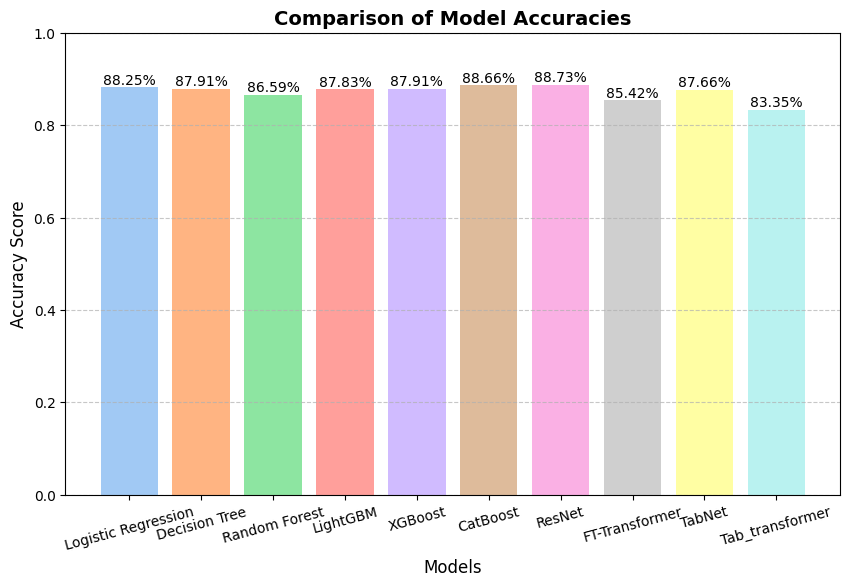

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'ResNet', 'FT-Transformer', 'TabNet', 'Tab_transformer']
accuracies = [log_acc, acc_dt, rf_acc, acc_lgb, acc_xgb, acc_cat, resnet_score, ftt_score, tabnet_score, tab_transformer_score]

colors = sns.color_palette("pastel", len(models))

plt.figure(figsize=(10, 6))

# 바 차트 그리기
bars = plt.bar(models, accuracies, color=colors,  linewidth=1.2)

plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{acc:.2%}",
             ha='center', va='bottom', fontsize=10)


plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.title("Comparison of Model Accuracies", fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()